# Fine-tuning Azure OpenAI GPT-4o for Chart Analysis

1. Retrieve and prepare dataset
2. Configure and start fine-tuning 
3. Deploy the fine-tuned model
4. Perform infere examples
5. Evaluate model baseline versus fine-tuned performance  

This project utilizes the ChartQA dataset introduced by Masry et al. in their paper, *ChartQA: A Benchmark for Question Answering about Charts with Visual and Logical Reasoning* (Findings of ACL 2022). We acknowledge the authors for providing this valuable resource. For more details, refer to the publication: [ChartQA: ACL 2022](https://aclanthology.org/2022.findings-acl.177).

> Reference: https://github.com/Azure/gen-cv/blob/main/vision-fine-tuning/01-AOAI-vision-fine-tuning-starter/README.md


## 1 Setup

In [1]:
import base64
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import requests
import sys

from azure.identity import DefaultAzureCredential
from datasets import load_dataset
from datetime import datetime
from dotenv import load_dotenv
from io import BytesIO, StringIO
from IPython.display import display
from openai import AzureOpenAI
from PIL import Image
from tenacity import retry, stop_after_attempt, wait_fixed
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Azure OpenAI version: {openai.__version__}")

Azure OpenAI version: 1.58.1


In [4]:
now = datetime.now()
today = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

Today is 2025-01-13 08:00:06


In [5]:
project_name = "chart-qa-v4"

train_samples = 1000  # you can increase these values to have more precision. First we will use few images to speed up the required time.
val_samples = 100
test_samples = 80

In [6]:
bold_start, bold_end = '\033[1m', '\033[0m'

SYSTEM_PROMPT = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [7]:
load_dotenv("azure.env")

api_key = os.getenv("api_key")
azure_endpoint = os.getenv("azure_endpoint")
subscription_id = os.getenv("subscription_id")
resource_name = os.getenv("resource_name")
rg_name = os.getenv("rg_name")

In [8]:
client = AzureOpenAI(api_key=api_key,
                     api_version="2024-10-21",
                     azure_endpoint=azure_endpoint)

## 2 Helper functions

In [9]:
def encode_image(image, quality=100):
    """
    Encode an image into a base64 string in JPEG format.
    """

    if image.mode != 'RGB':
        image = image.convert('RGB')  # Convert to RGB
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def date_sorted_df(details_dict):
    """
    Create a pandas DataFrame from a dictionary and sort it by a 'created' or 'created_at' timestamp column for displaying OpenAI API tables.
    """
    df = pd.DataFrame(details_dict)

    if 'created' in df.columns:
        df.rename(columns={'created': 'created_at'}, inplace=True)

    # Convert 'created_at' from Unix timestamp to human-readable date/time format
    df['created_at'] = pd.to_datetime(
        df['created_at'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

    if 'finished_at' in df.columns:
        # Convert 'finished_at' from Unix timestamp to human-readable date/time format, keeping null values as is
        df['finished_at'] = pd.to_datetime(
            df['finished_at'], unit='s',
            errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

    # Sort DataFrame by 'created_at' in descending order
    df = df.sort_values(by='created_at', ascending=False)

    return df


def show_ft_metrics(results_df, window_size=5):
    """
    Plot fine-tuning metrics including loss and accuracy for training and validation.
    """
    filtered_df = results_df.dropna(subset=['valid_loss'])
    filtered_df = filtered_df.loc[filtered_df['valid_loss'] != -1.0]
    results_df_smooth = results_df.rolling(window=window_size).mean()
    filtered_df_smooth = filtered_df.rolling(window=window_size).mean()

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_loss'],
             color='blue')
    plt.title('Train Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_mean_token_accuracy'],
             color='green')
    plt.title('Train Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_loss'],
             color='red')
    plt.title('Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 4)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_mean_token_accuracy'],
             color='orange')
    plt.title('Validation Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

## 3 Retrieve and prepare dataset

Fine-tuning for images is possible with JSONL dataset files similar to the process of sending images as input to the chat completion API.
Images can be provided as HTTP URLs (as shown below) or data URLs containing base64-encoded images.

```json
{
  "messages": [
    { "role": "system", "content": "You are an assistant that identifies uncommon cheeses." },
    { "role": "user", "content": "What is this cheese?" },
    { "role": "user", "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/3/36/Danbo_Cheese.jpg"
          }
        }
      ]
    },
    { "role": "assistant", "content": "Danbo" }
  ]
}
```
The following cell converts the ChartQA dataset from HuggingFace into this JSONL format by using base64-encoded images. Depending on your training data format, you will likely need to perform a few changes for reusing the code for your other use cases. 

In [10]:
ds = load_dataset("HuggingFaceM4/ChartQA")
display(ds)

# sample training, validation, and test examples
ds_train = ds['train'].shuffle(seed=42).select(range(train_samples))
ds_val = ds['val'].shuffle(seed=42).select(range(val_samples))
ds_test = ds['test'].shuffle(seed=42).select(range(test_samples))

# convert to pandas dataframe
ds_train = ds_train.to_pandas()
ds_val = ds_val.to_pandas()
ds_test = ds_test.to_pandas()

# convert byte strings to images
ds_train['image'] = ds_train['image'].apply(
    lambda x: Image.open(BytesIO(x['bytes'])))
ds_val['image'] = ds_val['image'].apply(
    lambda x: Image.open(BytesIO(x['bytes'])))
ds_test['image'] = ds_test['image'].apply(
    lambda x: Image.open(BytesIO(x['bytes'])))

# Convert array type of 'label' column into string only if the current data type is object
if ds_train['label'].dtype == 'object':
    ds_train['label'] = ds_train['label'].apply(lambda x: x[0])

if ds_val['label'].dtype == 'object':
    ds_val['label'] = ds_val['label'].apply(lambda x: x[0])

if ds_test['label'].dtype == 'object':
    ds_test['label'] = ds_test['label'].apply(lambda x: x[0])

ds_train = ds_train.rename(columns={'query': 'question', 'label': 'answer'})
ds_val = ds_val.rename(columns={'query': 'question', 'label': 'answer'})
ds_test = ds_test.rename(columns={'query': 'question', 'label': 'answer'})

ds_train = ds_train[['question', 'answer', 'image']]
ds_val = ds_val[['question', 'answer', 'image']]
ds_test = ds_test[['question', 'answer', 'image']]

DatasetDict({
    train: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 28299
    })
    val: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 2500
    })
})

In [11]:
ds_train

,question,answer,image
0,What is the sales performance of accessories b...,36,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,Is the cardiovascular disease more then sum of...,Yes,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,What was the youth unemployment rate in Bosnia...,33.97,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What was MWG's net revenue in 2019?,102.17,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,What was the infant mortality rate in Uzbekist...,15.6,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
995,What was France's crude birth rate in 1800?,29.4,<PIL.PngImagePlugin.PngImageFile image mode=RG...
996,How many colored segments are less than 10?,3,<PIL.PngImagePlugin.PngImageFile image mode=RG...
997,What was the fertility rate in Yemen in 2018?,3.79,<PIL.PngImagePlugin.PngImageFile image mode=RG...
998,What was the leading brewing company in Canada...,Molson Coors Brewing Company,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [12]:
ds_val

,question,answer,image
0,What was the value of the pizza delivery marke...,6.2,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,What is the smallest value represented,9,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,Is Croatia global hunger index extremely alarm...,No,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What was Russia's fertility rate in 2020?,1.74,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,What is the ratio of fixed broadband in the ye...,1,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
95,What is the total percentage revenue share of ...,41,<PIL.PngImagePlugin.PngImageFile image mode=RG...
96,In what year did the Sun have the highest reac...,2013,<PIL.PngImagePlugin.PngImageFile image mode=RG...
97,Find the median value of all the bars?,0.68,<PIL.PngImagePlugin.PngImageFile image mode=RG...
98,Which year(s) had the greatest difference betw...,"[2010/11, 2011/12, 2012/13]",<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [13]:
ds_test

,question,answer,image
0,Which party is least likely to approve NSA sur...,Independent,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,What is the estimated number of passengers tra...,252,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,What the difference in value between Papua New...,0.08,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What percentage of North America's GDP did B2C...,1.14,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,How much revenue did Pinterest generate in the...,706,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
75,How many years does the poverty percentage ros...,3,<PIL.PngImagePlugin.PngImageFile image mode=RG...
76,Does the line increase or decrease from 2000 t...,No,<PIL.PngImagePlugin.PngImageFile image mode=RG...
77,What is the average of all the bars ?,42.25,<PIL.PngImagePlugin.PngImageFile image mode=RG...
78,Which country has a export value of 6.02 milli...,Canada,<PIL.PngImagePlugin.PngImageFile image mode=RG...


QUESTION: Is the cardiovascular disease more then sum of all the other disease ?


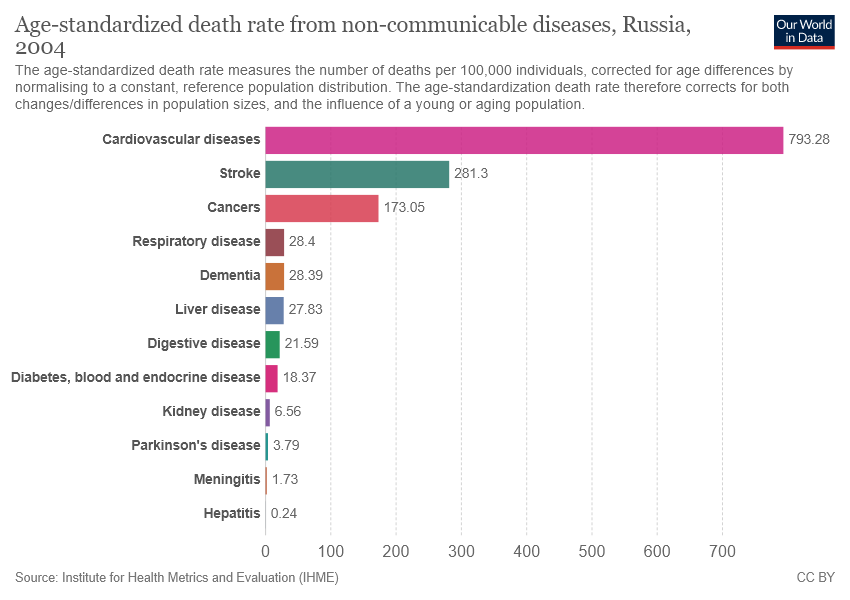

ANSWER: Yes


In [14]:
idx = 1

print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('ANSWER:', ds_train.iloc[idx]['answer'])

QUESTION: What was the unemployment rate in Massachusetts in 2020?


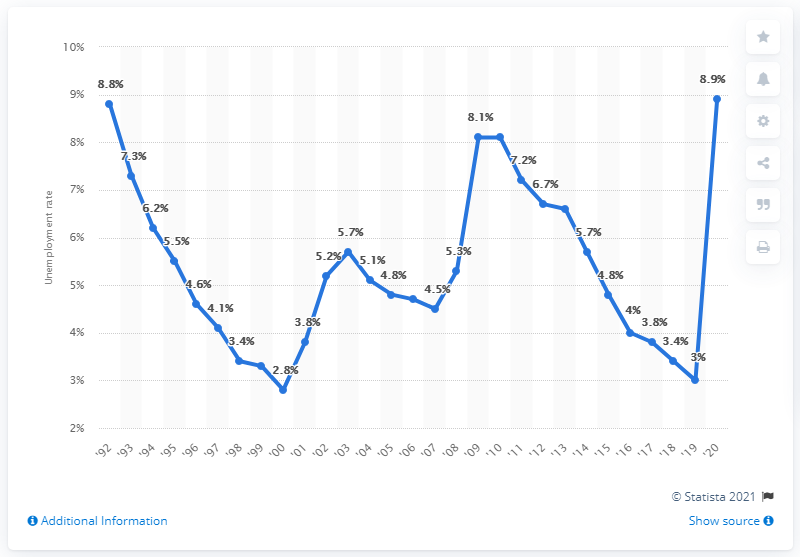

ANSWER: 8.9


In [15]:
idx = 10

print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('ANSWER:', ds_train.iloc[idx]['answer'])

QUESTION: What's the value of green bar in 2017?


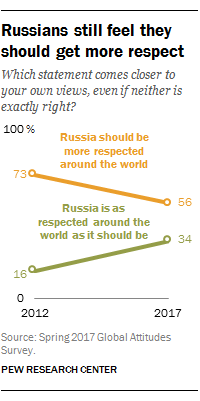

ANSWER: 34


In [16]:
idx = 50

print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('ANSWER:', ds_train.iloc[idx]['answer'])

In [17]:
# Create dataset splits as local JSONL files
splits = ['train', 'val', 'test']
datasets = [ds_train, ds_val, ds_test]

for split, dataset in zip(splits, datasets):
    dataset_file = f"{project_name}-{split}.jsonl"
    print(f"Generating {dataset_file} with {dataset.shape[0]} samples.")

    json_data = []
    base64_prefix = "data:image/jpeg;base64,"

    for idx, example in tqdm(enumerate(dataset.itertuples()),
                             total=dataset.shape[0]):
        try:
            system_message = {"role": "system", "content": SYSTEM_PROMPT}

            encoded_image = encode_image(example.image, quality=80)
            user_message = {
                "role":
                "user",
                "content": [{
                    "type": "text",
                    "text": f"Question [{idx}]: {example.question}"
                }, {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{base64_prefix}{encoded_image}"
                    }
                }]
            }
            assistant_message = {
                "role": "assistant",
                "content": example.answer
            }

            json_data.append({
                "messages": [system_message, user_message, assistant_message]
            })
        except KeyError as e:
            print(f"Missing field in example {idx}: {e}")
        except Exception as e:
            print(f"Error processing example {idx}: {e}")

    with open(dataset_file, "w") as f:
        for message in json_data:
            json.dump(message, f)
            f.write("\n")

Generating chart-qa-v4-train.jsonl with 1000 samples.


100%|██████████| 1000/1000 [00:13<00:00, 74.17it/s]


Generating chart-qa-v4-val.jsonl with 100 samples.


100%|██████████| 100/100 [00:01<00:00, 77.67it/s]


Generating chart-qa-v4-test.jsonl with 80 samples.


100%|██████████| 80/80 [00:01<00:00, 72.54it/s]


In [18]:
!ls *.jsonl -lh

-rwxrwxrwx 1 root root 4.6M Jan 13 08:01 chart-qa-v4-test.jsonl
-rwxrwxrwx 1 root root  57M Jan 13 08:01 chart-qa-v4-train.jsonl
-rwxrwxrwx 1 root root 5.3M Jan 13 08:01 chart-qa-v4-val.jsonl


## 4 Configure and start fine-tuning job

In [19]:
# upload training file
train_file = client.files.create(file=open(f"{project_name}-train.jsonl",
                                           "rb"),
                                 purpose="fine-tune")

# upload validation file
val_file = client.files.create(file=open(f"{project_name}-val.jsonl", "rb"),
                               purpose="fine-tune")

Here is some guidance if you want to adjust the hyperparameters of the fine-tuning process. You can keep them as `None` to use default values. 

| Hyperparameter                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Batch size`                            | The batch size to use for training. When set to default, batch_size is calculated as 0.2% of examples in training set and the max is 256.                                                           |
| `Learning rate multiplier` | The fine-tuning learning rate is the original learning rate used for pre-training multiplied by this multiplier. We recommend experimenting with values between 0.5 and 2. Empirically, we've found that larger learning rates often perform better with larger batch sizes. Must be between 0.0 and 5.0. |
| `Number of epochs`       | Number of training epochs. An epoch refers to one full cycle through the data set. If set to default, number of epochs will be determined dynamically based on the input data. |
| `Seed`  | The seed controls the reproducibility of the job. Passing in the same seed and job parameters should produce the same results, but may differ in rare cases. If a seed is not specified, one will be generated for you. |

In [20]:
baseline_model = "gpt-4o-2024-08-06"  # Not the deployment name model. This is the baseline

In [21]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

ft_job = client.fine_tuning.jobs.create(
    suffix=project_name,
    training_file=file_train,
    validation_file=file_val,
    # baseline model name (not the deployment name)
    model=baseline_model,
    seed=None,
    hyperparameters={
        "n_epochs": None,
        "batch_size": None,
        "learning_rate_multiplier": None,
    })

In [22]:
display(ft_job.to_dict())

{'id': 'ftjob-9bf11339900f49cfbe65e23c779785ca',
 'created_at': 1736755299,
 'hyperparameters': {'batch_size': -1,
  'learning_rate_multiplier': 1.0,
  'n_epochs': -1},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'seed': 1253563762,
 'status': 'pending',
 'training_file': 'file-7a1748e9eb964fc89db1f006b503b648',
 'validation_file': 'file-39f3487489fc4e7ea4c4d1bd2d5fdb93',
 'estimated_finish': 1736762832,
 'suffix': 'chart-qa-v4'}

In [23]:
ft_jobs = client.fine_tuning.jobs.list(limit=5).to_dict()
date_sorted_df(pd.DataFrame(ft_jobs['data']))

,id,created_at,hyperparameters,model,object,seed,status,training_file,validation_file,estimated_finish,suffix,fine_tuned_model,finished_at,result_files,trained_tokens
0,ftjob-9bf11339900f49cfbe65e23c779785ca,2025-01-13 08:01:39,"{'batch_size': -1, 'learning_rate_multiplier':...",gpt-4o-2024-08-06,fine_tuning.job,1253563762,pending,file-7a1748e9eb964fc89db1f006b503b648,file-39f3487489fc4e7ea4c4d1bd2d5fdb93,1736762832,chart-qa-v4,NaN,NaN,NaN,NaN
1,ftjob-78f6ea66bcb24d329d9de90e4053b266,2025-01-12 17:52:03,"{'batch_size': 16, 'learning_rate_multiplier':...",gpt-4o-2024-08-06,fine_tuning.job,16054417,succeeded,file-0110d7af1f37486fb4849a210aeabc7e,file-4cd1fdb3fd754d429ca18f117c116b15,1736758375,chart-qa-v4,gpt-4o-2024-08-06.ft-78f6ea66bcb24d329d9de90e4...,2025-01-13 01:07:20,[file-24c2fdce41e14a8db40e216a7b60c8dd],354346785.0


In [34]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(f'Job status: {client.fine_tuning.jobs.list(limit=1).to_dict()["data"][0]["status"]}')

2025-01-13 08:08:48
Job status: pending


In [37]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(f'Job status: {client.fine_tuning.jobs.list(limit=1).to_dict()["data"][0]["status"]}')

2025-01-13 08:09:29
Job status: running


In [113]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(f'Job status: {client.fine_tuning.jobs.list(limit=1).to_dict()["data"][0]["status"]}')

2025-01-13 12:52:39
Job status: succeeded


> Wait until completion

In [115]:
job_id = date_sorted_df(pd.DataFrame(ft_jobs['data'])).at[0, 'id']
job_id

'ftjob-9bf11339900f49cfbe65e23c779785ca'

In [116]:
# Retrieve the state of a fine-tune
ft_job = client.fine_tuning.jobs.retrieve(job_id)
ft_job.to_dict()

{'id': 'ftjob-9bf11339900f49cfbe65e23c779785ca',
 'created_at': 1736755299,
 'fine_tuned_model': 'gpt-4o-2024-08-06.ft-9bf11339900f49cfbe65e23c779785ca-chart-qa-v4',
 'finished_at': 1736772639,
 'hyperparameters': {'batch_size': 2,
  'learning_rate_multiplier': 1.0,
  'n_epochs': 3},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'result_files': ['file-9b44803fa1ef4d7e9063d4333d07aaeb'],
 'seed': 1253563762,
 'status': 'succeeded',
 'trained_tokens': 44224200,
 'training_file': 'file-7a1748e9eb964fc89db1f006b503b648',
 'validation_file': 'file-39f3487489fc4e7ea4c4d1bd2d5fdb93',
 'estimated_finish': 1736762832,
 'suffix': 'chart-qa-v4'}

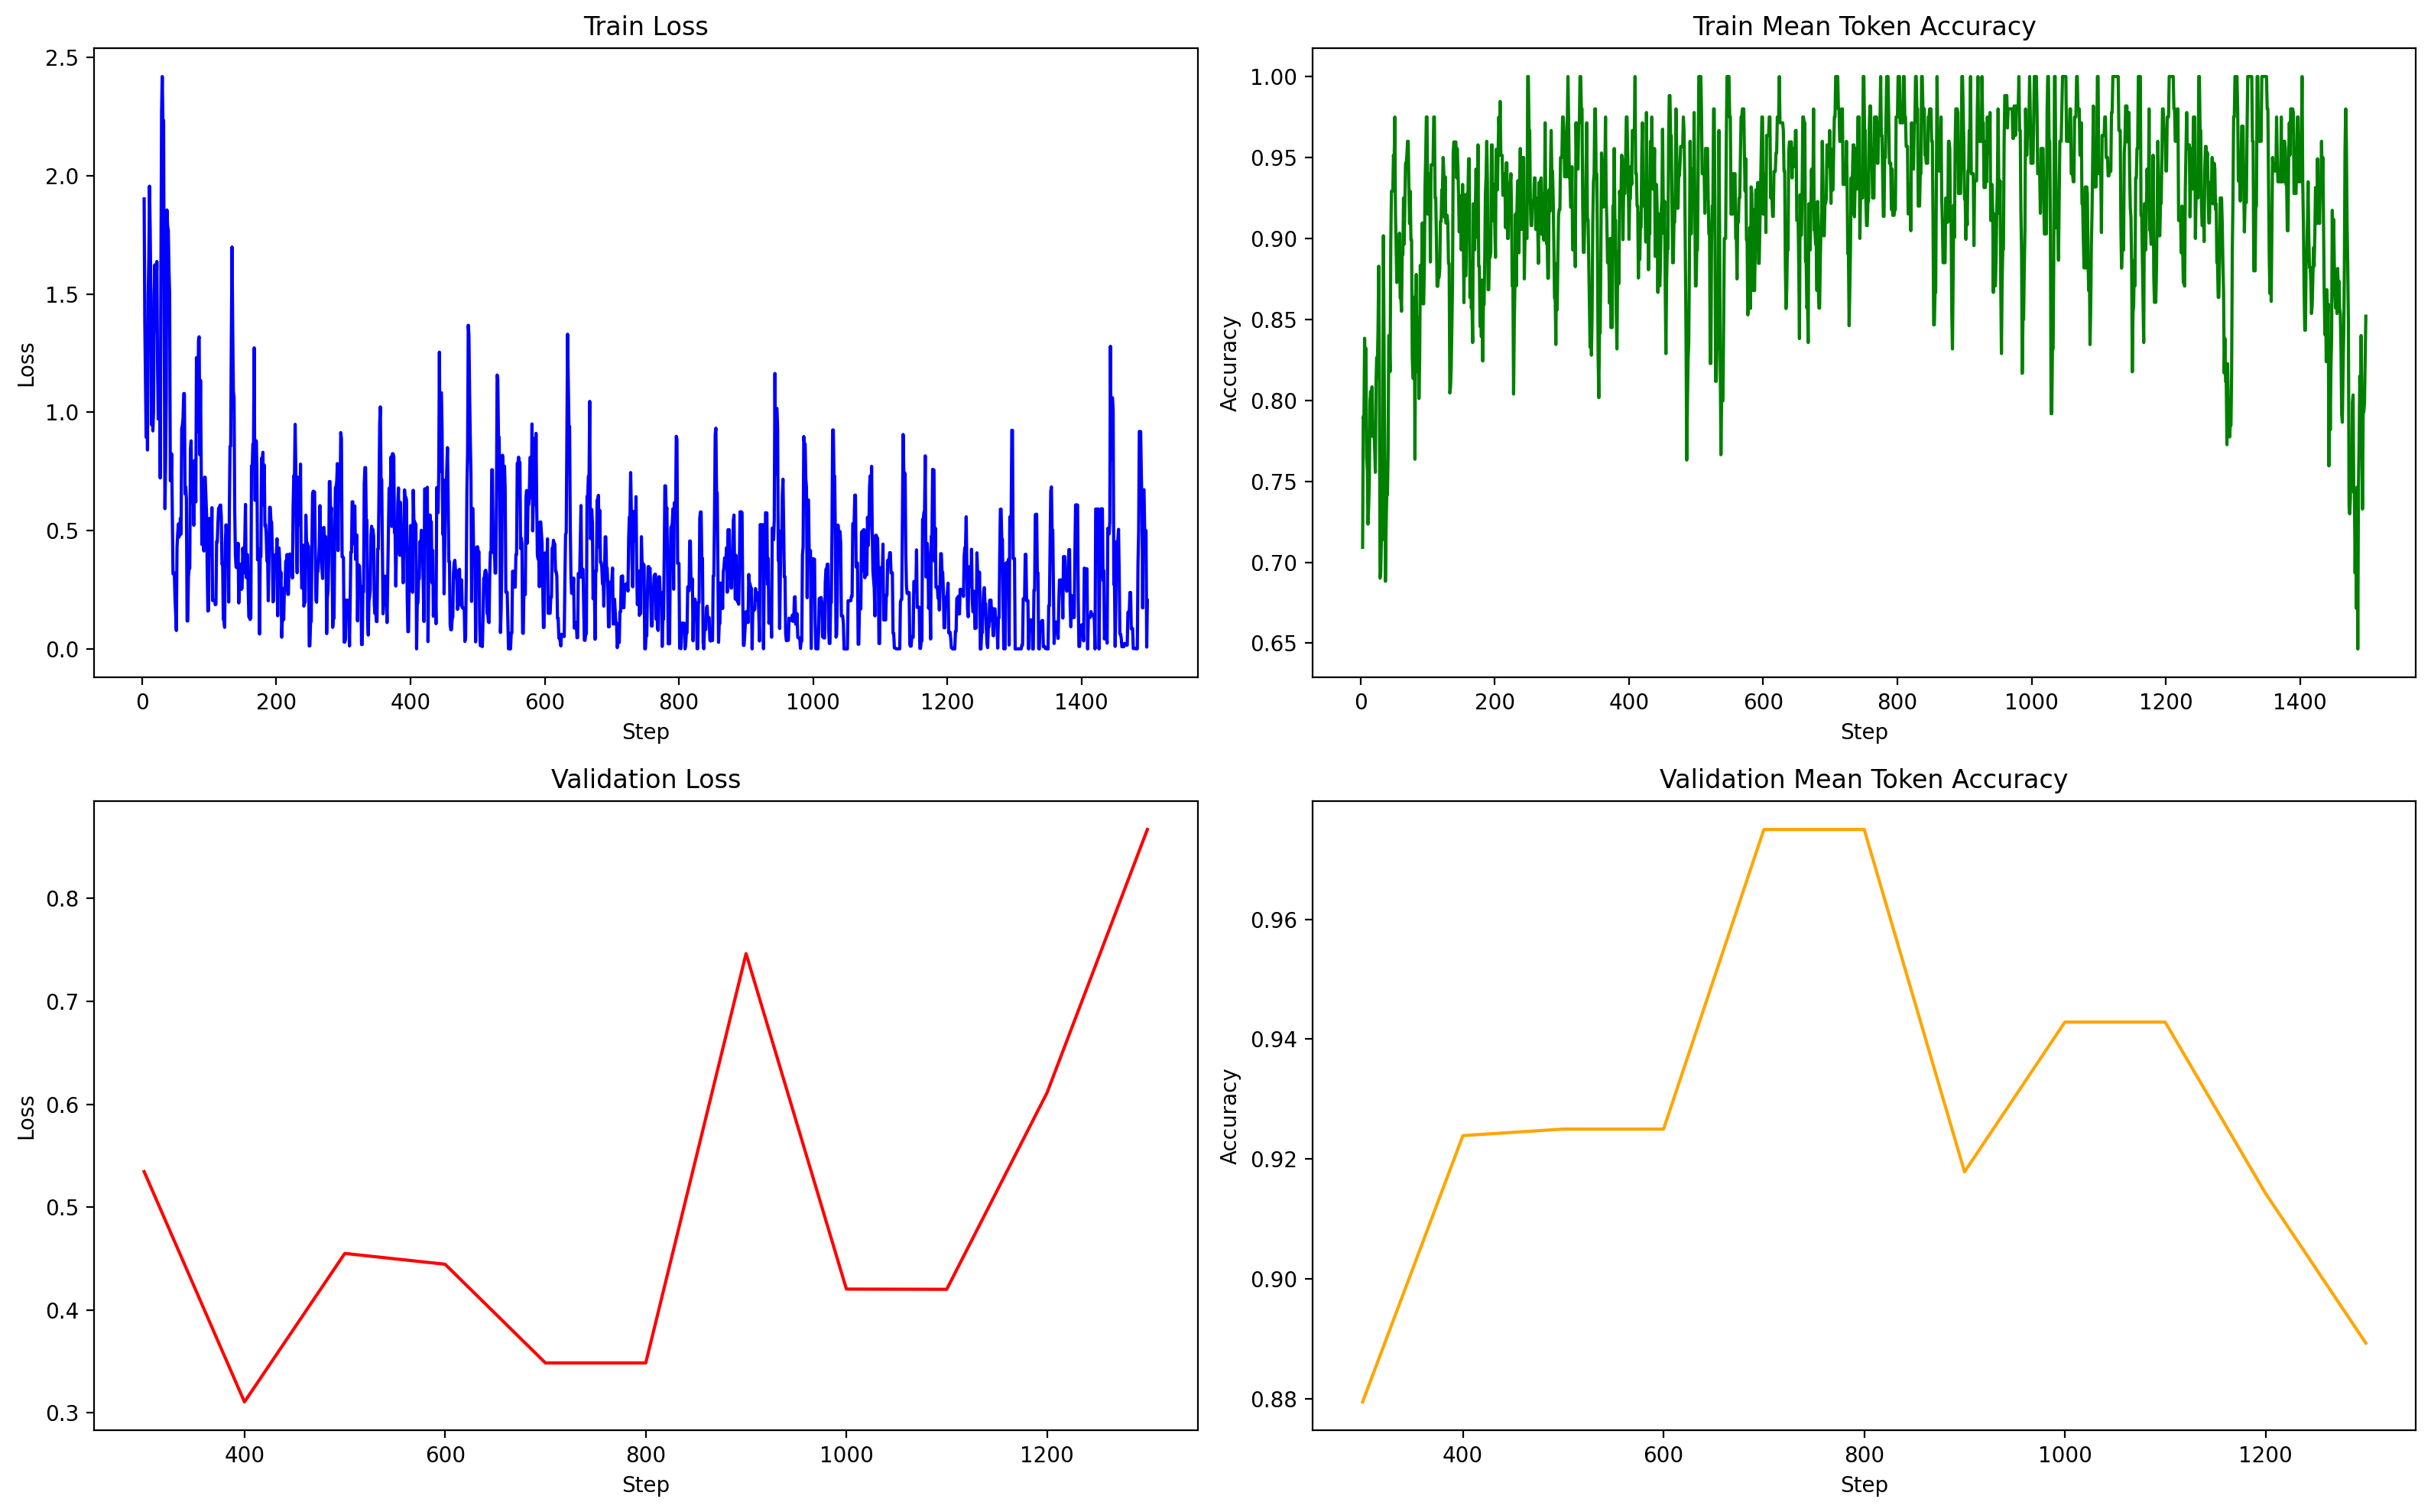

In [117]:
# Retrieve fine-tuning metrics from result file
result_file_id = ft_job.to_dict()['result_files'][0]
results_content = client.files.content(result_file_id).content.decode()

data_io = StringIO(results_content)
results_df = pd.read_csv(data_io)
show_ft_metrics(results_df)

Take a look at this table for an interpretation of above diagrams:  

| Metric                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `step`                            | The number of the training step. A training step represents a single pass, forward and backward, on a batch of training data.                                                           |
| `train_loss`, `validation_loss` | The loss for the training / validation batch |
| `train_mean_token_accuracy`       | The percentage of tokens in the training batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |
| `validation_mean_token_accuracy`  | The percentage of tokens in the validation batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |

## 5 Deploy fine-tuned model
> __Note__  
> Only one deployment is permitted for a customized model. An error occurs if you select an already-deployed customized model.  

The code below shows how to deploy the model using the Control Plane API. Take a look at the [Azure OpenAI fine-tuning documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo&pivots=programming-language-python#deploy-fine-tuned-model) for more details.

In [118]:
# List existing models
my_models = client.models.list().to_dict()
models_df = date_sorted_df(my_models['data'])

cols = [
    'status', 'capabilities', 'lifecycle_status', 'id', 'created_at', 'model'
]
print(
    f'Models of Azure OpenAI resource {bold_start}{resource_name}{bold_end}:')
display(models_df[cols].head())

Models of Azure OpenAI resource azureopenai-sweden-sr:


,status,capabilities,lifecycle_status,id,created_at,model
75,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-9bf11339900f49cfbe65e23c7...,2025-01-13 08:01:39,gpt-4o-2024-08-06
74,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-9bf11339900f49cfbe65e23c7...,2025-01-13 08:01:39,gpt-4o-2024-08-06
73,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-9bf11339900f49cfbe65e23c7...,2025-01-13 08:01:39,gpt-4o-2024-08-06
72,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-78f6ea66bcb24d329d9de90e4...,2025-01-12 17:52:03,gpt-4o-2024-08-06
71,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-78f6ea66bcb24d329d9de90e4...,2025-01-12 17:52:03,gpt-4o-2024-08-06


In [119]:
fine_tuned_model = "gpt-4o-2024-08-06.ft-9bf11339900f49cfbe65e23c779785ca-chart-qa-v4"
# it will look like gpt-4o-2024-08-06.ft-b044a9d3cf9c4228b5d393567f693b88

In [120]:
aoai_deployment_name = project_name  # AOAI deployment name. Use as model parameter for inferencing

credential = DefaultAzureCredential()
token = credential.get_token("https://management.azure.com/.default").token

deploy_params = {'api-version': "2023-05-01"}
deploy_headers = {
    'Authorization': 'Bearer {}'.format(token),
    'Content-Type': 'application/json'
}

deploy_data = {
    "sku": {
        "name": "standard",
        "capacity": 1
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": fine_tuned_model,
            "version": "1"
        }
    }
}
deploy_data = json.dumps(deploy_data)

request_url = f'https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{rg_name}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{aoai_deployment_name}'

print('Creating a new deployment...')
r = requests.put(request_url,
                 params=deploy_params,
                 headers=deploy_headers,
                 data=deploy_data)
print("Done")

Creating a new deployment...
Done


In [121]:
print(r)

<Response [201]>


In [122]:
print(r.reason)

Created


In [123]:
print(r.json())

{'id': '/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureopenai-suede-rg/providers/Microsoft.CognitiveServices/accounts/azureopenai-sweden-sr/deployments/chart-qa-v4', 'type': 'Microsoft.CognitiveServices/accounts/deployments', 'name': 'chart-qa-v4', 'sku': {'name': 'standard', 'capacity': 1}, 'properties': {'model': {'format': 'OpenAI', 'name': 'gpt-4o-2024-08-06.ft-9bf11339900f49cfbe65e23c779785ca-chart-qa-v4', 'version': '1'}, 'versionUpgradeOption': 'NoAutoUpgrade', 'capabilities': {'area': 'EUR', 'chatCompletion': 'true', 'jsonSchemaResponse': 'true', 'maxContextToken': '128000', 'maxOutputToken': '16384'}, 'provisioningState': 'Creating'}, 'systemData': {'createdBy': 'Serge.Retkowsky@microsoft.com', 'createdByType': 'User', 'createdAt': '2025-01-13T12:53:36.3165296Z', 'lastModifiedBy': 'Serge.Retkowsky@microsoft.com', 'lastModifiedByType': 'User', 'lastModifiedAt': '2025-01-13T12:53:36.3165296Z'}, 'etag': '"cdc167bb-90d8-42e4-ac72-560629ecf42b"'}


## 6 Evaluate default versus fine-tuned model

In [127]:
# Process test dataset with baseline model
ds_test['gpt-4o-base-pred'] = ds_test.apply(lambda row: query_image(row['image'], row['question'], baseline_model), axis=1)

In [128]:
output_csv_file = "evaluation.csv"

In [129]:
# Process test dataset with fine-tuned model
ds_test['gpt-4o-ft-pred'] = ds_test.apply(lambda row: query_image(row['image'], row['question'], baseline_model), axis=1)

# save intermediate results to csv
ds_test.to_csv(output_csv_file, index=False)

In [130]:
!ls $output_csv_file -lh

-rwxrwxrwx 1 root root 14K Jan 13 12:57 evaluation.csv


In [131]:
EVAL_SYSTEM_PROMPT = """You evaluate the factual correctness of a predicted answer about a diagram with a ground truth answer. 
The predicted answer might be formulated in a different way. Your only concern is if the predicted answer is correct from a factual perspective.
You are provided with the original question, the ground truth answer and the predicted answer.
You respond with either CORRECT or INCORRECT"""


@retry(stop=stop_after_attempt(3), wait=wait_fixed(10))
def evaluate(question,
             ground_truth_answer,
             predicted_answer,
             deployment=baseline_model):

    user_prompt = f"Original question: {question} \nGround truth answer: {ground_truth_answer}\nPredicted answer: {predicted_answer}"

    response = client.chat.completions.create(
        model=baseline_model,
        messages=[{
            "role": "system",
            "content": EVAL_SYSTEM_PROMPT
        }, {
            "role": "user",
            "content": user_prompt
        }],
        temperature=0,
    )

    return response.choices[0].message.content


print(
    evaluate('what is the diagram title?',
             'comparison of tax rates in US states',
             'Tax Rate Comparison Across US States'))

CORRECT


In [132]:
# Validate prediction accuracy of baseline model
ds_test['gpt-4o-base-eval'] = ds_test.apply(lambda row: evaluate(row['question'], row['answer'], row['gpt-4o-base-pred'], baseline_model), axis=1)

In [133]:
# Validate prediction accuracy of fine-tuned model
ds_test['gpt-4o-ft-eval'] = ds_test.apply(lambda row: evaluate(row['question'], row['answer'], row['gpt-4o-ft-pred'], baseline_model), axis=1)

# save final  results to csv
ds_test.to_csv(output_csv_file, index=False)

In [134]:
ds_test = pd.read_csv(output_csv_file)

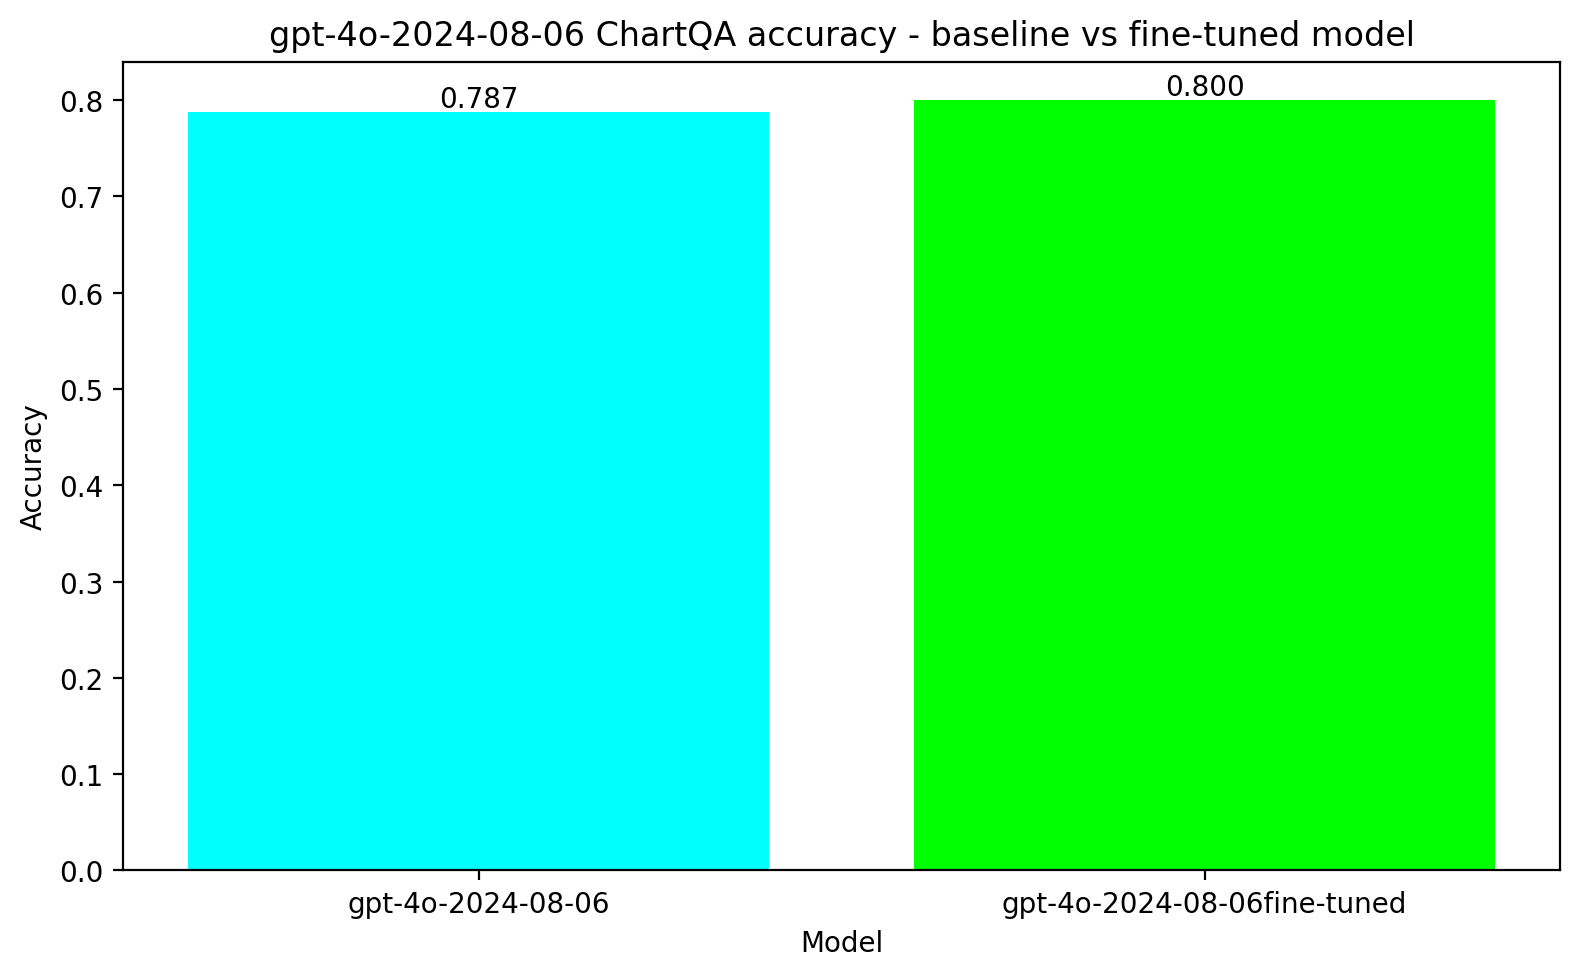

In [164]:
base_correct_count = ds_test['gpt-4o-base-eval'].value_counts().get(
    "CORRECT", 0)
base_eval_observations = ds_test.shape[0]
ft_correct_count = ds_test['gpt-4o-ft-eval'].value_counts().get("CORRECT", 0)
ft_eval_observations = ds_test.shape[0]

chart_data = {
    'title':
    'gpt-4o-2024-08-06 ChartQA accuracy - baseline vs fine-tuned model',
    'baseline': 'gpt-4o-2024-08-06',
    'fine-tuned': 'gpt-4o-2024-08-06fine-tuned',
    'baseline accuracy': base_correct_count / base_eval_observations,
    'fine-tuned accuracy': ft_correct_count / ft_eval_observations,
}

# Extract data for plotting
models = [chart_data['baseline'], chart_data['fine-tuned']]
accuracies = [
    chart_data['baseline accuracy'], chart_data['fine-tuned accuracy']
]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['cyan', 'lime'])

# Add titles and labels
plt.title(chart_data['title'])
plt.ylabel('Accuracy')
plt.xlabel('Model')

# Annotate bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()

> Small increase of quality. You can new add more images for the training part.

In [162]:
ds_test

,question,answer,image,gpt-4o-base-pred,gpt-4o-ft-pred,gpt-4o-base-eval,gpt-4o-ft-eval
0,Which party is least likely to approve NSA sur...,Independent,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Independent,Independent,CORRECT,CORRECT
1,What is the estimated number of passengers tra...,252,<PIL.PngImagePlugin.PngImageFile image mode=RG...,252 million,252 million,CORRECT,CORRECT
2,What the difference in value between Papua New...,0.08,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.08,0.08,CORRECT,CORRECT
3,What percentage of North America's GDP did B2C...,1.14,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1.14%,1.14%,CORRECT,CORRECT
4,How much revenue did Pinterest generate in the...,706,<PIL.PngImagePlugin.PngImageFile image mode=RG...,706 million U.S. dollars.,706 million U.S. dollars.,CORRECT,CORRECT
...,...,...,...,...,...,...,...
75,How many years does the poverty percentage ros...,3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,3 years,3 years,CORRECT,CORRECT
76,Does the line increase or decrease from 2000 t...,No,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Neither (remains constant).,Neither (remains constant).,CORRECT,CORRECT
77,What is the average of all the bars ?,42.25,<PIL.PngImagePlugin.PngImageFile image mode=RG...,42.25%,42.25%,INCORRECT,INCORRECT
78,Which country has a export value of 6.02 milli...,Canada,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Canada,Canada,CORRECT,CORRECT
